In [1]:
import torch
import triton
import triton.language as tl

In [2]:
@triton.jit
def vec_add_kernel(x_ptr, y_ptr, out_ptr, n_elements, block_size: tl.constexpr):
    # get the program's coordinate in the grid
    # since the grid is 1D, there are only M blocks in 0th axis
    # and this program is for one of those blocks
    pid = tl.program_id(axis=0)

    # now figure out the data offsets
    offsets = pid * block_size + tl.arange(0, block_size)

    # create a mask
    mask = offsets < n_elements

    # get pointers to relevant data
    x_ptrs = x_ptr + offsets
    y_ptrs = y_ptr + offsets
    out_ptrs = out_ptr + offsets

    # load data from global memory to shared memory
    x_vals = tl.load(x_ptrs, mask=mask, other=0)
    y_vals = tl.load(y_ptrs, mask=mask, other=0)
    
    # save the result to corresponding location
    tl.store(out_ptrs, x_vals + y_vals, mask=mask)




def vec_add(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    assert x.is_cuda == y.is_cuda
    assert x.is_contiguous()
    assert y.is_contiguous()
    assert x.ndim == y.ndim == 1
    assert x.numel() == y.numel()

    n_elements = x.numel()
    output = torch.empty_like(x)
    BLOCK_SIZE = 1024 # these many threads per block

    grid = (
        # these many blocks in the grid
        # n_elements might not be divisible by BLOCK_SIZE
        # so do a ceiling division e.g. 5/2 = 3
        triton.cdiv(n_elements, BLOCK_SIZE),
    ) # 1D grid
    vec_add_kernel[grid](x, y, output, n_elements=n_elements, block_size=BLOCK_SIZE)
    return output

In [6]:
x = torch.rand(size=(10000,), device='cuda')
y = torch.rand(size=(10000,), device='cuda')

torch_add = x + y
triton_add = vec_add(x, y)
torch.allclose(torch_add, triton_add)

True

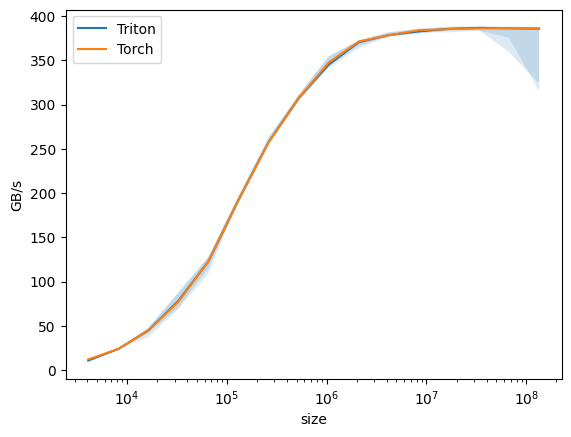

,size,Triton,Torch
0,4096.0,10.741259,12.000000
1,8192.0,23.813955,23.813955
2,16384.0,44.683637,44.521738
3,32768.0,78.267515,77.283017
4,65536.0,122.880003,122.880003
5,131072.0,192.000000,192.000000
6,262144.0,257.340315,257.003920
7,524288.0,307.200008,307.200008
8,1048576.0,345.077665,347.363956
9,2097152.0,370.434274,371.133541


In [9]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],
         x_vals=[2**i for i in range(12, 28, 1)], 
        x_log=True,
        line_arg='provider',
        line_vals=['triton', 'torch'],
        line_names=['Triton', 'Torch'],
        ylabel='GB/s',
        plot_name='vector-add-performance',
        args={}
    )
)
def benchmark(size: int, provider: str):
    x = torch.rand(size, device='cuda', dtype=torch.float32)
    y = torch.rand(size, device='cuda', dtype=torch.float32)

    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y, quantiles=quantiles)
    elif provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: vec_add(x, y), quantiles=quantiles)
    else:
        raise ValueError(f"unknown provider: {provider}")
    
    gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

benchmark.run(show_plots=True, return_df=True)